## Exploratory Analysis Notebook for Invoice Data

This notebook loads important libraries, and studies the characteristics in our training data

In [1]:
# import required libraries
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype

# for NLP processing
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# helper ML functions
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# ML classification models to try
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# scoring
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

Goal is to create a classifier that predicts a Condition given NotesOne and NotesTwo which for this analysis, we combine it into one column called NotesFull

- NotesOne: The diagnosis text provided by doctor as it appears on the invoice
- NotesTwo:  An optional field containing additional information about the reason for the condition
- Condition: The ground-truth label for what the condition is



In [4]:
claim_df = pd.read_csv("{}/PartII_Data/ExtractedData.csv".format(os.getcwd()))

In [5]:
claim_df[['NotesOne', 'NotesTwo', 'Condition']].head(10)

,NotesOne,NotesTwo,Condition
0,Anal Gland Surgery,NaN,NO COND
1,Atopy,NaN,ALLERGY (ALLERGIC)
2,ruptured CCL (right),NaN,"CRUCIATE RUPTURE (ACL, CCL)"
3,Dental,NaN,DENTAL DISEASE
4,TPLO,NaN,"CRUCIATE RUPTURE (ACL, CCL)"
5,ingested chicken wing bones,NaN,NO COND
6,Lumps on Left side,NaN,NO COND
7,Chocolate Ingestion,NaN,NO COND
8,urine infection,NaN,URINARY TRACT INFECTION
9,renal failure and neurologic disease,NaN,KIDNEY DISEASE


In [6]:
# data types of the columns
print(claim_df[['NotesOne', 'NotesTwo', 'Condition']].dtypes)

NotesOne     object
NotesTwo     object
Condition    object
dtype: object


In [7]:
# print the unique values in each columns
for col in claim_df[['NotesOne', 'NotesTwo', 'Condition']].columns:
    print("{} : {}\n".format(col, claim_df[col].unique()))


NotesOne : ['Anal Gland Surgery' 'Atopy' 'ruptured CCL (right)' ...
 'painful mouth and found tooth fracture' 'Keppra XR'
 'Dermatitis/Allergies']

NotesTwo : [nan 'Ear infection'
 'Came in for lumpectomy in mouth, also checking phenobarb levels. ' ...
 'clavamox - incision infection - first sign 6/12/18\nlabwork - diarrhea - first sign 4/29/18'
 'Lab work is for a sedated ear flush'
 'Loose stool from post-surgery medications']

Condition : ['NO COND' 'ALLERGY (ALLERGIC)' 'CRUCIATE RUPTURE (ACL, CCL)'
 'DENTAL DISEASE' 'URINARY TRACT INFECTION' 'KIDNEY DISEASE' 'DIARRHEA'
 'OTITIS EXTERNA' 'VOMITING' 'MASS(ES)' 'LIMPING' 'LIVER DISEASE'
 'SEIZURE' 'COUGH' 'GASTROENTERITIS' 'FRACTURE' 'FOREIGN BODY'
 'TOXIN INGESTION'
 'FOREIGN MATERIAL INGESTION(INGESTION OF FOREIGN MATERIAL)'
 'HIT BY CAR(VICTIM, PEDESTRIAN IN VEHICULAR AND/OR TRAFFIC ACCIDENT)'
 'LACRIMAL DUCT OBSTRUCTION, COMPLETE']



Here we can see the proportion of nans in each columns

In [8]:
# see proportion of nans in each columns
print(claim_df.apply(lambda col: col.isna().sum()*100/len(claim_df)))

NotesOne      0.009178
NotesTwo     94.822399
Condition     0.000000
dtype: float64


We will look at an example condition: ALLERGY (ALLERGIC), and see the similar terms associated with it

In [9]:
claim_df.loc[claim_df['Condition']=="ALLERGY (ALLERGIC)"]

,NotesOne,NotesTwo,Condition
1,Atopy,NaN,ALLERGY (ALLERGIC)
11,"Medication refill: Apoquel, Carprovet, Vetmedi...",NaN,ALLERGY (ALLERGIC)
14,Pain Relief and Allergies,NaN,ALLERGY (ALLERGIC)
17,Allergies (Shampoo only for Mika),NaN,ALLERGY (ALLERGIC)
23,ALLERGIES,NaN,ALLERGY (ALLERGIC)
...,...,...,...
98016,dermatitis,NaN,ALLERGY (ALLERGIC)
98032,otitis/allergies,Lab work is for a sedated ear flush,ALLERGY (ALLERGIC)
98048,intervertebral disc disease,NaN,ALLERGY (ALLERGIC)
98051,Allergies,NaN,ALLERGY (ALLERGIC)


Here, we can see the distribution of each Condition in our training data

Condition
ALLERGY (ALLERGIC)                                                      8175
COUGH                                                                   1291
CRUCIATE RUPTURE (ACL, CCL)                                             2551
DENTAL DISEASE                                                          3067
DIARRHEA                                                                6011
FOREIGN BODY                                                            1257
FOREIGN MATERIAL INGESTION(INGESTION OF FOREIGN MATERIAL)               1509
FRACTURE                                                                2433
GASTROENTERITIS                                                         2695
HIT BY CAR(VICTIM, PEDESTRIAN IN VEHICULAR AND/OR TRAFFIC ACCIDENT)      213
KIDNEY DISEASE                                                          1634
LACRIMAL DUCT OBSTRUCTION, COMPLETE                                        2
LIMPING                                                           

<AxesSubplot:xlabel='Condition'>

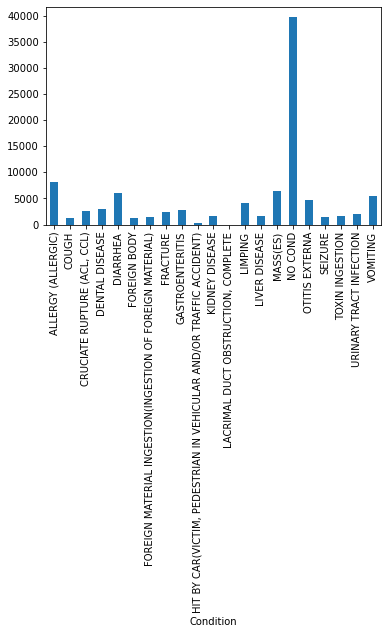

In [10]:
# Number of unique values for Condition column
print(claim_df.groupby('Condition').size())
 
# Plotting the bar chart to see freq dist of Condition column
claim_df.groupby('Condition').size().plot(kind='bar')

Note that our data is skewed because of the abundance of categories in the 'NO COND' categorization

Let's tokenize the data and see what words are common per condition.

In [11]:
os.chdir("/Users/rexxx/text_nlp/partII")
import preprocess_data as prep

# combine and do some data cleaning
train_df = claim_df.copy()
train_df['NotesOne'] = prep.fillNA(input_df = train_df, col = 'NotesOne')
train_df['NotesTwo'] = prep.fillNA(input_df = train_df, col = 'NotesTwo')
train_df= prep.custom_processing(train_df, col = None)
train_df["NotesFull"] = prep.remove_special_char(input_df = train_df, col = "NotesFull")
train_df["NotesFull"] = prep.remove_punctuation(input_df = train_df, col = "NotesFull")
train_df["NotesFull"] = prep.convert_to_lower_case(input_df = train_df, col = "NotesFull")
train_df["NotesFull"] = prep.remove_stop_words(input_df = train_df, col = "NotesFull")
train_df.head()

18-Sep-22 16:40:40 - Fill in NAs with constant method
18-Sep-22 16:40:40 - Fill in NAs with constant method
18-Sep-22 16:40:40 - Fill in NAs with constant method
18-Sep-22 16:40:40 - Fill in NAs with constant method
18-Sep-22 16:40:40 - Early dataset pre-processing done.
18-Sep-22 16:40:40 - Removing special characters ...
18-Sep-22 16:40:40 - Removing punctuation ...
18-Sep-22 16:40:40 - Convert to lower case ...
18-Sep-22 16:40:40 - Removing stop words ...


,NotesOne,NotesTwo,Condition,NotesFull
0,Anal Gland Surgery,,NO COND,anal gland surgery
1,Atopy,,ALLERGY (ALLERGIC),atopy
2,ruptured CCL (right),,"CRUCIATE RUPTURE (ACL, CCL)",ruptured ccl right
3,Dental,,DENTAL DISEASE,dental
4,TPLO,,"CRUCIATE RUPTURE (ACL, CCL)",tplo


In [12]:
train_df["NotesFull"] = prep.tokenize_data(train_df, col = "NotesFull")

18-Sep-22 16:43:38 - Tokenizing data ...


In [13]:
train_df.head()

,NotesOne,NotesTwo,Condition,NotesFull
0,Anal Gland Surgery,,NO COND,"[anal, gland, surgery]"
1,Atopy,,ALLERGY (ALLERGIC),[atopy]
2,ruptured CCL (right),,"CRUCIATE RUPTURE (ACL, CCL)","[ruptured, ccl, right]"
3,Dental,,DENTAL DISEASE,[dental]
4,TPLO,,"CRUCIATE RUPTURE (ACL, CCL)",[tplo]


In [14]:
train_df["NotesFull"] = prep.stem(train_df, col = "NotesFull")


18-Sep-22 16:43:45 - Stemming data ...


In [15]:
train_df.head()

,NotesOne,NotesTwo,Condition,NotesFull
0,Anal Gland Surgery,,NO COND,"[anal, gland, surgeri]"
1,Atopy,,ALLERGY (ALLERGIC),[atopi]
2,ruptured CCL (right),,"CRUCIATE RUPTURE (ACL, CCL)","[ruptur, ccl, right]"
3,Dental,,DENTAL DISEASE,[dental]
4,TPLO,,"CRUCIATE RUPTURE (ACL, CCL)",[tplo]


In [16]:
train_df["NotesFull"] = prep.lemmatize(train_df, col = "NotesFull")

18-Sep-22 16:43:52 - Lemmatizing data ...


In [17]:
train_df.head()

,NotesOne,NotesTwo,Condition,NotesFull
0,Anal Gland Surgery,,NO COND,"[anal, gland, surgeri]"
1,Atopy,,ALLERGY (ALLERGIC),[atopi]
2,ruptured CCL (right),,"CRUCIATE RUPTURE (ACL, CCL)","[ruptur, ccl, right]"
3,Dental,,DENTAL DISEASE,[dental]
4,TPLO,,"CRUCIATE RUPTURE (ACL, CCL)",[tplo]


In [18]:
# plot by condition

In [19]:
# USE EXAMPLE
# use explode to expand the lists into separate rows
dfe = train_df.NotesFull.explode().to_frame().reset_index(drop=True)

# groupby the values in the column, get the count and sort
dfg = dfe.groupby('NotesFull').NotesFull.count() \
                               .reset_index(name='count') \
                               .sort_values(['count'], ascending=False) \
                               .head(20).reset_index(drop=True)


In [20]:
dfg.head()

,NotesFull,count
0,vomit,7799
1,ear,7476
2,diarrhea,7084
3,infect,6794
4,allergi,6364


<AxesSubplot:xlabel='NotesFull'>

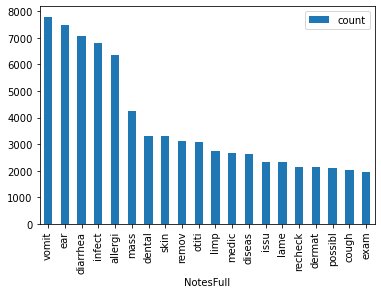

In [21]:
dfg.plot.bar(x='NotesFull')

In [22]:
word_dict = {}
for row in range(train_df.shape[0]):
    cond = train_df.loc[row, 'Condition']
    if cond not in word_dict.keys():
        word_dict[cond] = train_df.loc[row, 'NotesFull']
    else:
        word_dict[cond] += train_df.loc[row, 'NotesFull']

In [23]:
# loop through and count occurence of each word?
print(list(word_dict.keys()))

['NO COND', 'ALLERGY (ALLERGIC)', 'CRUCIATE RUPTURE (ACL, CCL)', 'DENTAL DISEASE', 'URINARY TRACT INFECTION', 'KIDNEY DISEASE', 'DIARRHEA', 'OTITIS EXTERNA', 'VOMITING', 'MASS(ES)', 'LIMPING', 'LIVER DISEASE', 'SEIZURE', 'COUGH', 'GASTROENTERITIS', 'FRACTURE', 'FOREIGN BODY', 'TOXIN INGESTION', 'FOREIGN MATERIAL INGESTION(INGESTION OF FOREIGN MATERIAL)', 'HIT BY CAR(VICTIM, PEDESTRIAN IN VEHICULAR AND/OR TRAFFIC ACCIDENT)', 'LACRIMAL DUCT OBSTRUCTION, COMPLETE']


In [24]:
pd.DataFrame(word_dict['ALLERGY (ALLERGIC)'])

,0
0,atopi
1,medic
2,refil
3,apoquel
4,carprovet
...,...
24571,disc
24572,diseas
24573,allergi
24574,dermat


In [25]:
save_pds = []
for cond in word_dict.keys():
    # create dataframe 
    sample_cond = pd.DataFrame({"Words":word_dict[cond]})
    sample_cond['Condition']= cond
    # use explode to expand the lists into separate rows
    dfe = sample_cond.Words.explode().to_frame().reset_index(drop=True)

    # groupby the values in the column, get the count and sort, and get top 20 words
    dfg = dfe.groupby('Words').Words.count() \
                                   .reset_index(name='count') \
                                   .sort_values(['count'], ascending=False) \
                                   .head(20).reset_index(drop=True)
    dfg['Condition'] = cond
    save_pds.append(dfg)

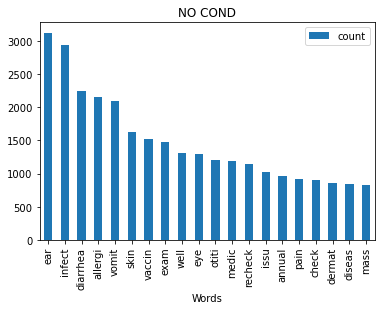

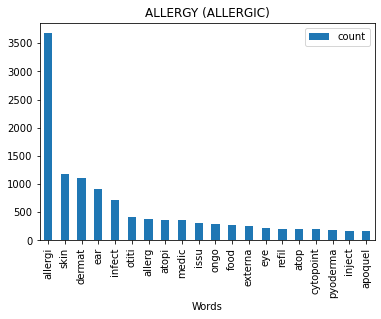

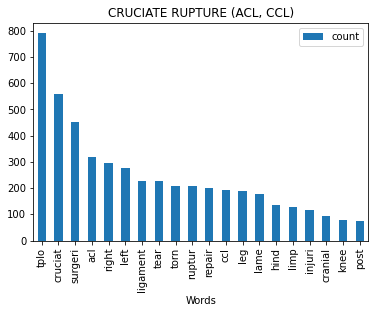

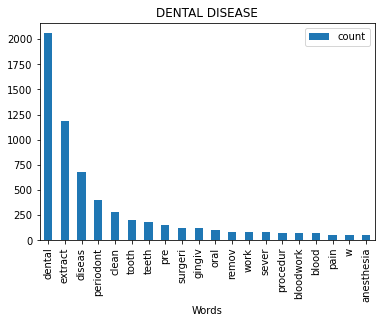

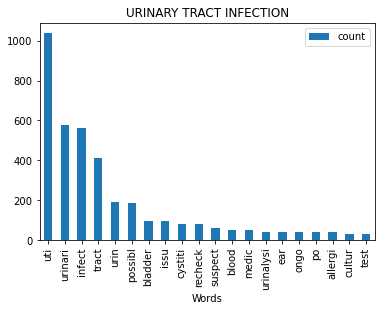

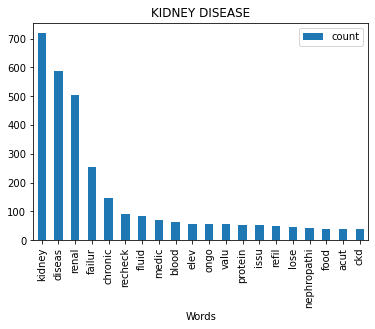

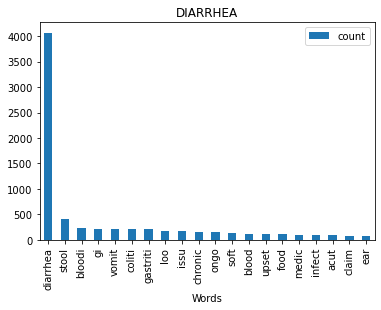

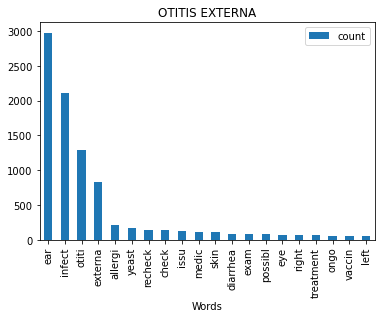

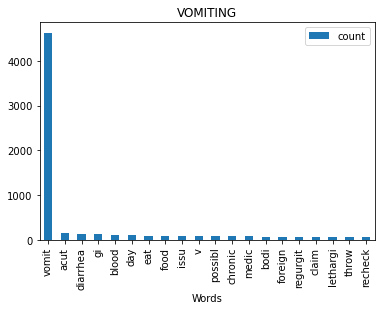

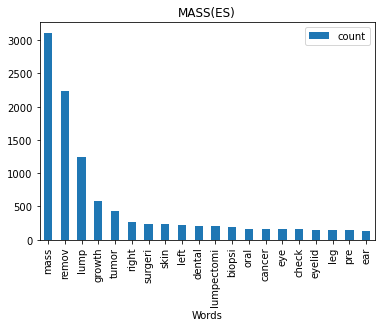

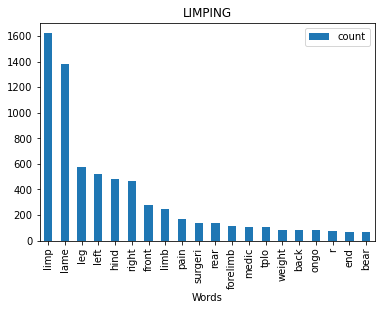

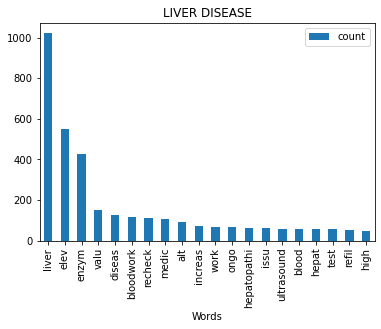

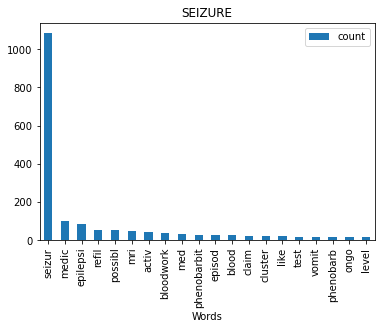

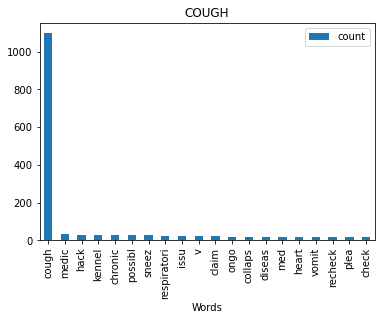

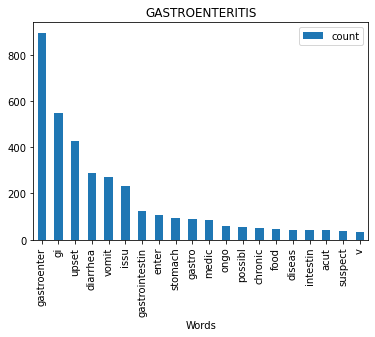

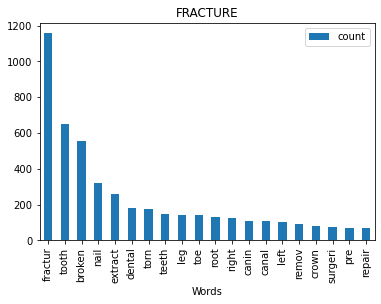

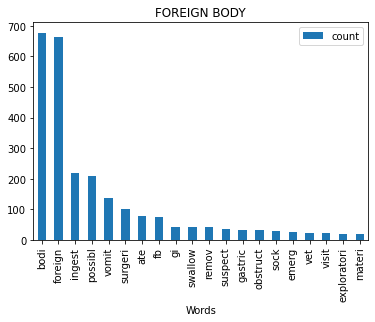

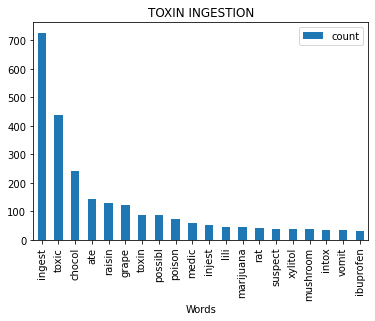

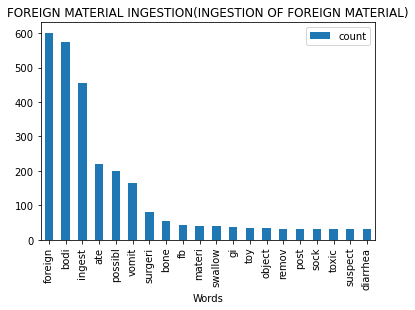

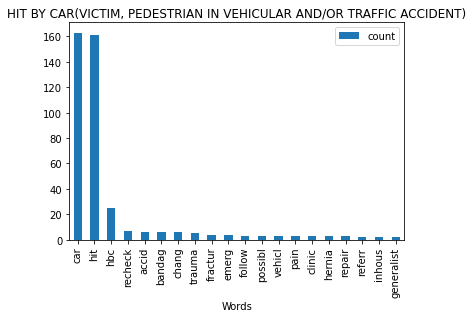

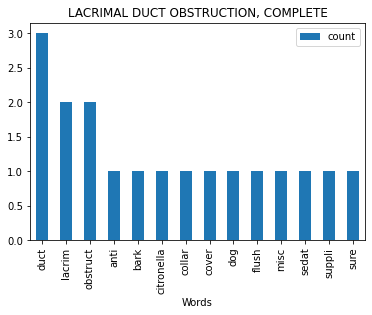

In [26]:
# Plotting the bar chart to see freq dist of Condition column
for dfg in save_pds:
    ax = dfg.plot.bar(x='Words')
    ax.set_title(dfg['Condition'].unique().tolist()[0])

Looking at the incorrectly selected data

In [2]:
import pandas as pd
check = pd.read_csv("/Users/rexxx/text_nlp/test.csv")

In [4]:
check.loc[check['y_actual'] != check['y_pred']]

,Unnamed: 0,NotesFull,y_actual,y_pred
0,13873,urinari issu,URINARY TRACT INFECTION,NO COND
2,26743,consist vomit extend period time,NO COND,LIMPING
3,71119,atop demat otiti externa,NO COND,ALLERGY (ALLERGIC)
6,64675,dermal mass dental diseas healthcheck plu pre ...,MASS(ES),NO COND
8,27288,induc vomit grape,TOXIN INGESTION,FOREIGN MATERIAL INGESTION(INGESTION OF FOREIG...
...,...,...,...,...
19592,94709,list,LIVER DISEASE,NO COND
19596,24622,torn ccl,NO COND,"CRUCIATE RUPTURE (ACL, CCL)"
19600,22784,tplo,ALLERGY (ALLERGIC),"CRUCIATE RUPTURE (ACL, CCL)"
19601,27895,kennel cough,NO COND,COUGH


In [12]:
check.loc[check['NotesFull'].str.contains("uti", na=False)]

,Unnamed: 0,NotesFull,y_actual,y_pred
112,55904,uti,URINARY TRACT INFECTION,URINARY TRACT INFECTION
147,16520,uti,URINARY TRACT INFECTION,URINARY TRACT INFECTION
185,76104,uti,NO COND,URINARY TRACT INFECTION
221,66117,urinaylsi make sure uti present,URINARY TRACT INFECTION,NO COND
239,16673,uti,NO COND,URINARY TRACT INFECTION
...,...,...,...,...
19180,90428,uti,URINARY TRACT INFECTION,URINARY TRACT INFECTION
19281,43590,uti,URINARY TRACT INFECTION,URINARY TRACT INFECTION
19498,66167,uti,URINARY TRACT INFECTION,URINARY TRACT INFECTION
19533,36094,intern medicin consult chronic uti anorexia,URINARY TRACT INFECTION,NO COND


In [13]:
check.loc[check['NotesFull'].str.contains("uti", na=False)].y_actual.unique()

array(['URINARY TRACT INFECTION', 'NO COND', 'VOMITING', 'DIARRHEA',
       'DENTAL DISEASE', 'MASS(ES)', 'CRUCIATE RUPTURE (ACL, CCL)',
       'OTITIS EXTERNA', 'ALLERGY (ALLERGIC)', 'SEIZURE', 'LIMPING',
       'LIVER DISEASE', 'KIDNEY DISEASE', 'FOREIGN BODY',
       'FOREIGN MATERIAL INGESTION(INGESTION OF FOREIGN MATERIAL)'],
      dtype=object)

In [18]:
check.loc[check['NotesFull'].str.contains(" uti ", na=False, regex = False)].NotesFull.unique()

array(['urinaylsi make sure uti present',
       'vulvoplasti chronic uti perivulvar dermat', 'possibl uti itch',
       'spay uti antibiot', 'dcm djd anal saccul uti hypertens',
       'suspect uti allergi', 'pas stone urin uti eye infect allergi',
       'suspect uti hormon test', 'bladder infect uti bladder infect uti',
       'urinari accid r uti v cystic calculus v',
       'follow initi uti visit koda still show symptom despit cephalexin urin retest vet notic uti still progress note bacteria suscept cephalexin antibiot put enrofloxacin urin retest day later show improv day enrofloxacin',
       'enter flagyl uti rxed cefpodoxim', 'cush uti urinari incontin',
       'recheck uti medic shampoo',
       'chronic uti rule urinari stone ultrasound',
       'cutan lymphoma epiderm collarett possibl uti pannu',
       'allergi claro apoquel omega ear cytolog irrig uti urinalysi ultrasound urin cultur',
       'possibl uti diarrhea',
       'possibl uti also found ear infect day must wro

In [14]:
check.loc[check['NotesFull'].str.contains("uti", na=False)].y_pred.unique()

array(['URINARY TRACT INFECTION', 'NO COND', 'ALLERGY (ALLERGIC)',
       'DENTAL DISEASE', 'KIDNEY DISEASE', 'CRUCIATE RUPTURE (ACL, CCL)',
       'LIVER DISEASE'], dtype=object)

In [24]:
check.shape

(19612, 4)

In [22]:
check.loc[(check['NotesFull']=="uti") & (check['y_actual'] != "URINARY TRACT INFECTION")].shape

(44, 4)

In [23]:
check.loc[(check['NotesFull']=="diarrhea") & (check['y_actual'] != "DIARRHEA")].shape

(199, 4)

Could do some cleaning here with the input data's classification so that it's more accurate.

In [25]:
check.loc[(check['NotesFull']=="diarrhea") & (check['y_actual'] != "DIARRHEA"), 'y_actual'] = "DIARRHEA"

In [26]:
check.loc[(check['NotesFull']=="uti") & (check['y_actual'] != "URINARY TRACT INFECTION"), 'y_actual'] = "URINARY TRACT INFECTION"